In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 4 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline_augmented'
)
print(datestring)

cifar10_4____2020_08_26_14_04_31_424572_baseline_augmented


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

### Augmentation

In [11]:
#https://github.com/tanzhenyu/image_augmentation/blob/master/image_augmentation/image/image_ops.py
IMAGE_DTYPES = [tf.uint8, tf.float32, tf.float16, tf.float64]


def _check_image_dtype(image):
    assert image.dtype in IMAGE_DTYPES, "image with " + str(image.dtype) + " is not supported for this operation"


@tf.function
def invert(image, name=None):
    """Inverts the pixels of an `image`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "invert"):
        if image.dtype == tf.uint8:
            inv_image = 255 - image
        else:
            inv_image = 1. - image
        return inv_image


@tf.function
def cutout(image, size=16, color=None, name=None):
    """This is an implementation of Cutout as described in "Improved
    Regularization of Convolutional Neural Networks with Cutout" by
    DeVries & Taylor (https://arxiv.org/abs/1708.04552).
    It applies a random square patch of specified `size` over an `image`
    and by replacing those pixels with value of `color`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        size: A 0-D int tensor or single int value that is divisible by 2.
        color: A single pixel value (grayscale) or tuple of 3 values (RGB),
            in case a single value is used for RGB image the value is tiled.
            Gray color (128) is used by default.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "cutout"):
        image_shape = tf.shape(image)
        height, width, channels = image_shape[0], image_shape[1], image_shape[2]

        loc_x = tf.random.uniform((), 0, width, tf.int32)
        loc_y = tf.random.uniform((), 0, height, tf.int32)

        ly, lx = tf.maximum(0, loc_y - size // 2), tf.maximum(0, loc_x - size // 2)
        uy, ux = tf.minimum(height, loc_y + size // 2), tf.minimum(width, loc_x + size // 2)

        gray = tf.constant(128)
        if color is None:
            if image.dtype == tf.uint8:
                color = tf.repeat(gray, channels)
            else:
                color = tf.repeat(tf.cast(gray, tf.float32) / 255., channels)
        else:
            color = tf.convert_to_tensor(color)
        color = tf.cast(color, image.dtype)

        cut = tf.ones((uy - ly, ux - lx, channels), image.dtype)

        top = image[0: ly, 0: width]
        between = tf.concat([
            image[ly: uy, 0: lx],
            cut * color,
            image[ly: uy, ux: width]
        ], axis=1)
        bottom = image[uy: height, 0: width]

        cutout_image = tf.concat([top, between, bottom], axis=0)
        return cutout_image


@tf.function
def solarize(image, threshold, name=None):
    """Inverts the pixels of an `image` above a certain `threshold`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        threshold: A 0-D int / float tensor or int / float value for setting
            inversion threshold.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "solarize"):
        threshold = tf.cast(threshold, image.dtype)

        inverted_image = invert(image)
        solarized_image = tf.where(image < threshold, image, inverted_image)
        return solarized_image


@tf.function
def solarize_add(image, addition, threshold=None, name=None):
    """Adds `addition` intensity to each pixel and inverts the pixels
    of an `image` above a certain `threshold`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        addition: A 0-D int / float tensor or int / float value that is to be
            added to each pixel.
        threshold: A 0-D int / float tensor or int / float value for setting
            inversion threshold. 128 (int) / 0.5 (float) is used by default.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "solarize_add"):
        if threshold is None:
            threshold = tf.image.convert_image_dtype(tf.constant(128, tf.uint8), image.dtype)

        addition = tf.cast(addition, image.dtype)
        added_image = image + addition

        dark, bright = tf.constant(0, tf.uint8), tf.constant(255, tf.uint8)
        added_image = tf.clip_by_value(added_image, tf.image.convert_image_dtype(dark, image.dtype),
                                       tf.image.convert_image_dtype(bright, image.dtype))
        return solarize(added_image, threshold)


@tf.function
def posterize(image, num_bits, name=None):
    """Reduces the number of bits used to represent an `image`
    for each color channel.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        num_bits: A 0-D int tensor or integer value representing number of bits.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "posterize"):
        orig_dtype = image.dtype
        image = tf.image.convert_image_dtype(image, tf.uint8)

        num_bits = tf.cast(num_bits, tf.int32)
        mask = tf.cast(2 ** (8 - num_bits) - 1, tf.uint8)
        mask = tf.bitwise.invert(mask)

        posterized_image = tf.bitwise.bitwise_and(image, mask)
        posterized_image = tf.image.convert_image_dtype(posterized_image, orig_dtype, saturate=True)
        return posterized_image


@tf.function
def equalize(image, name=None):
    """Equalizes the `image` histogram. In case of an RGB image, equalization
    individually for each channel.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "equalize"):
        orig_dtype = image.dtype
        image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
        image = tf.cast(image, tf.int32)

        def equalize_grayscale(image_channel):
            """Equalizes the histogram of a grayscale (2D) image."""
            bins = tf.constant(256, tf.int32)

            histogram = tf.math.bincount(image_channel, minlength=bins)
            nonzero = tf.where(tf.math.not_equal(histogram, 0))
            nonzero_histogram = tf.reshape(tf.gather(histogram, nonzero), [-1])
            step = (tf.reduce_sum(nonzero_histogram) - nonzero_histogram[-1]) // (bins - 1)

            # use a lut similar to PIL
            def normalize(histogram, step):
                norm_histogram = (tf.math.cumsum(histogram) + (step // 2)) // step
                norm_histogram = tf.concat([[0], norm_histogram], axis=0)
                norm_histogram = tf.clip_by_value(norm_histogram, 0, bins - 1)
                return norm_histogram

            return tf.cond(tf.math.equal(step, 0),
                           lambda: image_channel,
                           lambda: tf.gather(normalize(histogram, step), image_channel))

        channels_first_image = tf.transpose(image, [2, 0, 1])
        channels_first_equalized_image = tf.map_fn(equalize_grayscale, channels_first_image)
        equalized_image = tf.transpose(channels_first_equalized_image, [1, 2, 0])

        equalized_image = tf.cast(equalized_image, tf.uint8)
        equalized_image = tf.image.convert_image_dtype(equalized_image, orig_dtype)
        return equalized_image


@tf.function
def auto_contrast(image, name=None):
    """Normalizes `image` contrast by remapping the `image` histogram such
    that the brightest pixel becomes 1.0 (float) / 255 (unsigned int) and
    darkest pixel becomes 0.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "auto_contrast"):
        orig_dtype = image.dtype
        image = tf.image.convert_image_dtype(image, tf.float32)

        min_val, max_val = tf.reduce_min(image, axis=[0, 1]), tf.reduce_max(image, axis=[0, 1])

        norm_image = (image - min_val) / (max_val - min_val)
        norm_image = tf.image.convert_image_dtype(norm_image, orig_dtype, saturate=True)
        return norm_image


@tf.function
def blend(image1, image2, factor, name=None):
    """Blends an image with another using `factor`.
    Args:
        image1: An int or float tensor of shape `[height, width, num_channels]`.
        image2: An int or float tensor of shape `[height, width, num_channels]`.
        factor: A 0-D float tensor or single floating point value depicting
            a weight above 0.0 for combining the example_images.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image1` and `image2`.
    """
    _check_image_dtype(image1)
    _check_image_dtype(image2)
    assert image1.dtype == image2.dtype, "image1 type should exactly match type of image2"

    if factor == 0.0:
        return image1
    elif factor == 1.0:
        return image2
    else:
        with tf.name_scope(name or "blend"):
            orig_dtype = image2.dtype

            image1, image2 = tf.image.convert_image_dtype(image1, tf.float32), tf.image.convert_image_dtype(image2, tf.float32)
            scaled_diff = (image2 - image1) * factor

            blended_image = image1 + scaled_diff

            blended_image = tf.image.convert_image_dtype(blended_image, orig_dtype, saturate=True)
            return blended_image


@tf.function
def sample_pairing(image1, image2, weight, name=None):
    """Alias of `blend`. This is an implementation of SamplePairing
    as described in "Data Augmentation by Pairing Samples for Images Classification"
    by Inoue (https://arxiv.org/abs/1801.02929).
    Args:
        image1: An int or float tensor of shape `[height, width, num_channels]`.
        image2: An int or float tensor of shape `[height, width, num_channels]`.
        weight: A 0-D float tensor or single floating point value depicting
            a weight factor above 0.0 for combining the example_images.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image1`.
    """
    with tf.name_scope(name or "sample_pairing"):
        paired_image = blend(image1, image2, weight)
        return paired_image


@tf.function
def color(image, magnitude, name=None):
    """Adjusts the `magnitude` of color of an `image`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        magnitude: A 0-D float tensor or single floating point value above 0.0.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "color"):
        tiled_gray_image = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
        colored_image = blend(tiled_gray_image, image, magnitude)
        return colored_image


@tf.function
def sharpness(image, magnitude, name=None):
    """Adjusts the `magnitude` of sharpness of an `image`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        magnitude: A 0-D float tensor or single floating point value above 0.0.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "sharpness"):
        orig_dtype = image.dtype
        image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
        image = tf.cast(image, tf.float32)

        blur_kernel = tf.constant([[1, 1, 1],
                                   [1, 5, 1],
                                   [1, 1, 1]], tf.float32, shape=[3, 3, 1, 1]) / 13
        blur_kernel = tf.tile(blur_kernel, [1, 1, 3, 1])
        strides = [1, 1, 1, 1]

        # add extra dimension to image before conv
        blurred_image = tf.nn.depthwise_conv2d(image[None, ...], blur_kernel,
                                               strides, padding="VALID")
        blurred_image = tf.clip_by_value(blurred_image, 0., 255.)
        # remove extra dimension
        blurred_image = blurred_image[0]

        mask = tf.ones_like(blurred_image)
        extra_padding = tf.constant([[1, 1],
                                     [1, 1],
                                     [0, 0]], tf.int32)
        padded_mask = tf.pad(mask, extra_padding)
        padded_blurred_image = tf.pad(blurred_image, extra_padding)

        blurred_image = tf.where(padded_mask == 1, padded_blurred_image, image)

        sharpened_image = blend(blurred_image, image, magnitude)

        sharpened_image = tf.cast(sharpened_image, tf.uint8)
        sharpened_image = tf.image.convert_image_dtype(sharpened_image, orig_dtype)
        return sharpened_image


@tf.function
def brightness(image, magnitude, name=None):
    """Adjusts the `magnitude` of brightness of an `image`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        magnitude: A 0-D float tensor or single floating point value above 0.0.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "brightness"):
        dark = tf.zeros_like(image)
        bright_image = blend(dark, image, magnitude)
        return bright_image


@tf.function
def contrast(image, magnitude, name=None):
    """Adjusts the `magnitude` of contrast of an `image`.
    Args:
        image: An int or float tensor of shape `[height, width, num_channels]`.
        magnitude: A 0-D float tensor or single floating point value above 0.0.
        name: An optional string for name of the operation.
    Returns:
        A tensor with same shape and type as that of `image`.
    """
    _check_image_dtype(image)

    with tf.name_scope(name or "contrast"):
        orig_dtype = image.dtype
        image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)

        grayed_image = tf.image.rgb_to_grayscale(image)
        grayed_image = tf.cast(grayed_image, tf.int32)
        bins = tf.constant(256, tf.int32)
        histogram = tf.math.bincount(grayed_image, minlength=bins)
        histogram = tf.cast(histogram, tf.float32)
        mean = tf.reduce_sum(tf.cast(grayed_image, tf.float32)) / tf.reduce_sum(histogram)
        mean = tf.clip_by_value(mean, 0.0, 255.0)

        mean = tf.cast(mean, tf.uint8)
        mean_image = tf.ones_like(grayed_image, tf.uint8) * mean
        mean_image = tf.image.grayscale_to_rgb(mean_image)

        contrast_image = blend(mean_image, image, magnitude)
        contrast_image = tf.image.convert_image_dtype(contrast_image, orig_dtype, saturate=True)
        return contrast_image

In [12]:
1 + int(1 / 0.25)

5

In [13]:
import tensorflow_addons as tfa


def get_augment(
    augment_probability=0.25,
    autocontrast_range=[1e-5, 1],
    brightness_range=[1e-5, 1.5],
    contrast_range=[1e-5, 1],
    color_range=[-1, 1],
    cutout_range=[0, 0.5],
    equalize_range=[0, 1],
    invert_range=[0, 1],
    posterize_range=[1, 8],
    rescale_range=[0.5, 1],
    rescale_range_x_range=0.5,
    rescale_range_y_range=0.5,
    rotate_range=[-45, 45],
    sharpness_range=[0, 1],
    solarize_range=[0, 1],
    shear_x_range=[-0.3, 0.3],
    shear_y_range=[-0.3, 0.3],
    translate_x_range=0.3,
    translate_y_range=0.3,
    dims=(32, 32, 3),
):
    def augment(image, label):

        image = tf.image.random_flip_left_right(image)

        random_switch = tf.cast(
            tf.random.uniform(
                (1,), minval=0, maxval=1 + int(1 / augment_probability), dtype=tf.int32
            )[0]
            == 1,
            tf.bool,
        )

        if random_switch:
            return image, label
        
        # Autocontrast 0-1
        ac_img = auto_contrast(image)
        ac_blend_factor = tf.random.uniform(
            (1,),
            minval=autocontrast_range[0],
            maxval=autocontrast_range[1],
            dtype=tf.float32,
        )[0]
        image = blend(ac_img, image, ac_blend_factor)
        # Brightness 0-1
        brightness_factor = tf.random.uniform(
            (1,),
            minval=brightness_range[0],
            maxval=brightness_range[1],
            dtype=tf.float32,
        )[0]
        image = brightness(image, brightness_factor)
        # color 0-1
        color_factor = tf.random.uniform(
            (1,), minval=color_range[0], maxval=color_range[1], dtype=tf.float32
        )[0]
        image = tf.image.adjust_hue(image, color_factor)
        # contrast 0-1
        contrast_factor = tf.random.uniform(
            (1,), minval=contrast_range[0], maxval=contrast_range[1], dtype=tf.float32
        )[0]
        image = tf.image.adjust_contrast(image, contrast_factor)
        # cutout 0-0.5
        cutout_factor = tf.random.uniform(
            (1,), minval=cutout_range[0], maxval=cutout_range[1], dtype=tf.float32
        )[0]
        image = cutout(image, tf.cast(cutout_factor * dims[0], tf.int32))
        # equalize 0-1
        equalize_factor = tf.random.uniform(
            (1,), minval=equalize_range[0], maxval=equalize_range[1], dtype=tf.float32
        )[0]
        equalized_image = equalize(image)
        image = blend(equalized_image, image, equalize_factor)
        # invert 0-1
        invert_factor = tf.random.uniform(
            (1,), minval=invert_range[0], maxval=invert_range[1], dtype=tf.float32
        )[0]
        invert_image = invert(image)
        image = blend(invert_image, image, invert_factor)
        # posterize 1-8
        posterize_factor = tf.random.uniform(
            (1,), minval=posterize_range[0], maxval=posterize_range[1], dtype=tf.int32
        )[0]
        image = posterize(image, posterize_factor)
        # rescale 0.5-1
        rescale_factor = tf.random.uniform(
            (1,), minval=rescale_range[0], maxval=rescale_range[1], dtype=tf.float32
        )[0]
        image = tf.image.random_crop(image, [dims[0]*rescale_factor, dims[1]*rescale_factor, dims[2]])
        image = tf.image.resize(image, [dims[0], dims[1]])
        
        # sqeeze x or y
        randint_hor = tf.random.uniform(
            (2,),
            minval=0,
            maxval=tf.cast(rescale_range_x_range * dims[0], tf.int32),
            dtype=tf.int32,
        )[0]
        randint_vert = tf.random.uniform(
            (2,),
            minval=0,
            maxval=tf.cast(rescale_range_y_range * dims[1], tf.int32),
            dtype=tf.int32,
        )[0]
        image = tf.image.resize(
            image, (dims[0] + randint_vert * 2, dims[1] + randint_hor * 2)
        )
        # image = tf.image.crop_to_bounding_box(image, randint_vert,randint_hor,28,28)
        image = tf.image.resize_with_pad(image, dims[0], dims[1])

        image = tf.image.resize_with_crop_or_pad(
            image, dims[0] + 3, dims[1] + 3
        )  # crop 6 pixels
        image = tf.image.random_crop(image, size=dims)

        # rotate -45 45
        rotate_factor = tf.random.uniform(
            (1,),
            minval=rotate_range[0] / 360,
            maxval=rotate_range[1] / 360,
            dtype=tf.float32,
        )[0]
        image = tfa.image.rotate(image, rotate_factor, interpolation="BILINEAR",)

        # sharpness 0,1
        sharpness_factor = tf.random.uniform(
            (1,), minval=sharpness_range[0], maxval=sharpness_range[1], dtype=tf.float32
        )[0]
        image = sharpness(image, sharpness_factor)
        # shear_x -0.3, 3
        shear_x_factor = tf.random.uniform(
            (1,), minval=shear_x_range[0], maxval=shear_x_range[1], dtype=tf.float32
        )[0]

        image = (
            tf.cast(
                tfa.image.shear_x(
                    tf.cast(image * 255, tf.uint8), shear_x_factor, replace=0
                ),
                tf.float32,
            )
            / 255.0
        )
        # shear_y -0.3, 3
        shear_y_factor = tf.random.uniform(
            (1,), minval=shear_x_range[0], maxval=shear_y_range[1], dtype=tf.float32
        )[0]
        image = (
            tf.cast(
                tfa.image.shear_y(
                    tf.cast(image * 255, tf.uint8), shear_y_factor, replace=0
                ),
                tf.float32,
            )
            / 255.0
        )

        # smooth 0,1
        smooth_factor = tf.random.uniform((1,), minval=0, maxval=1, dtype=tf.float32)[0]
        # solarize 0,1
        solarize_factor = tf.random.uniform(
            (1,), minval=solarize_range[0], maxval=solarize_range[1], dtype=tf.float32
        )[0]
        image = solarize(image, solarize_factor)
        # translate x -0.3, 0.3
        translate_x_factor = tf.random.uniform(
            (1,), minval=0, maxval=translate_x_range * 2, dtype=tf.float32
        )[0]
        # translate y -0.3, 0.3
        translate_y_factor = tf.random.uniform(
            (1,), minval=0, maxval=translate_y_range * 2, dtype=tf.float32
        )[0]

        image = tf.image.resize_with_crop_or_pad(
            image,
            dims[0] + tf.cast(translate_x_factor * dims[0], tf.int32),
            dims[1] + tf.cast(translate_x_factor * dims[1], tf.int32),
        )  # crop 6 pixels
        image = tf.image.random_crop(image, size=dims)
        
        image = tf.clip_by_value(image, 0.0,1.0)

        return image, label

    return augment


augment = get_augment(
    augment_probability=0.25,
    autocontrast_range=[0.25, 1],
    brightness_range=[0.25, 2.0],
    contrast_range=[0.5, 1],
    cutout_range=[0, 0.5],
    color_range=[-0.1, 0.1],
    equalize_range=[0.25, 1],
    invert_range=[0.9, 1],
    posterize_range=[1, 8],
    rescale_range=[0.5, 1],
    rotate_range=[-45, 45],
    sharpness_range=[0.25, 1],
    solarize_range=[0.9, 1],
    shear_x_range=[-0.15, 0.15],
    shear_y_range=[-0.15, 0.15],
    translate_x_range=0.15,
    translate_y_range=0.15,
    dims=(32, 32, 3),
)

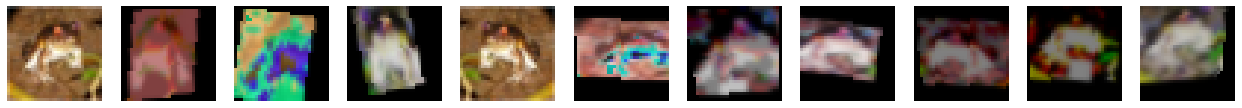

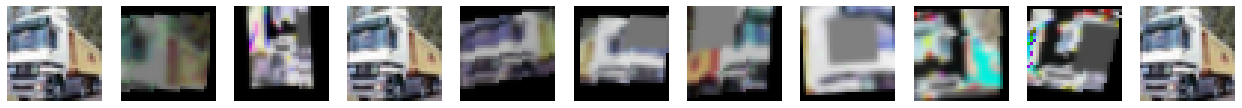

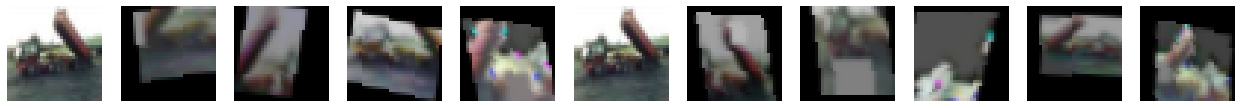

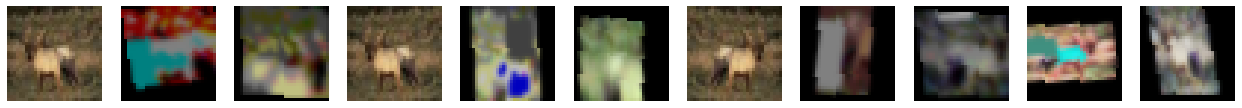

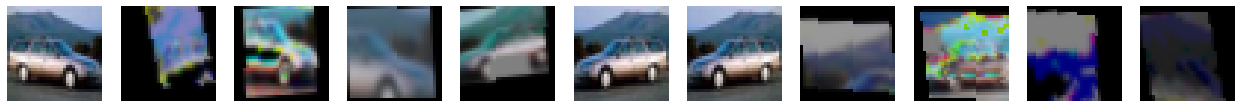

In [14]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(np.squeeze(X_train[i]), cmap = plt.cm.Greys)
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        aug_img = np.squeeze(augment(X_train[i], Y_train[i])[0])
        ax.matshow(aug_img, cmap = plt.cm.Greys, vmin=0, vmax=1)
        ax.axis('off')

### train

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

In [16]:
import tensorflow_addons as tfa

In [17]:
opt = tf.keras.optimizers.Adam(1e-4)
opt = tfa.optimizers.MovingAverage(opt)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(opt, loss = loss, metrics=['accuracy'])

In [18]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [19]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [20]:
from livelossplot import PlotLossesKerasTF
# plot losses callback
plotlosses = PlotLossesKerasTF()

In [21]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .repeat()
    .shuffle(len(X_labeled))
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

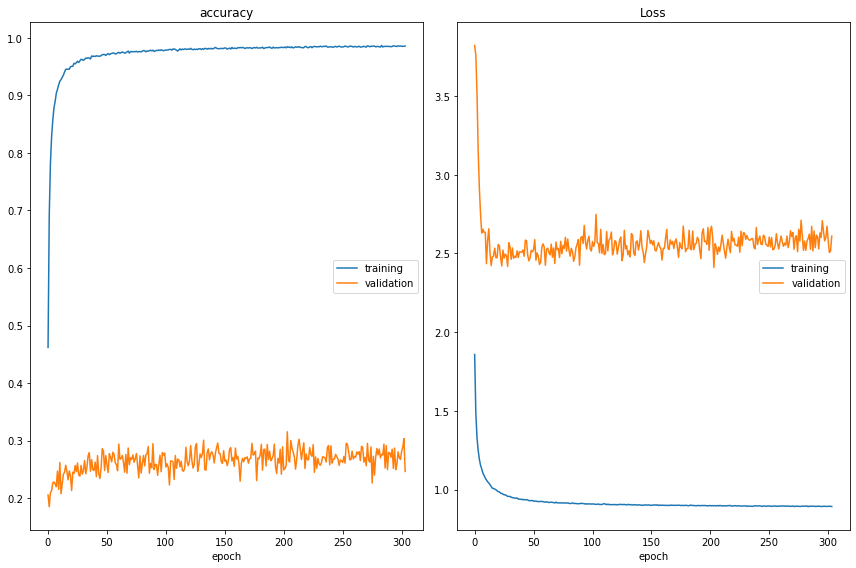

accuracy
	training         	 (min:    0.462, max:    0.987, cur:    0.986)
	validation       	 (min:    0.185, max:    0.315, cur:    0.246)
Loss
	training         	 (min:    0.891, max:    1.858, cur:    0.892)
	validation       	 (min:    2.412, max:    3.822, cur:    2.610)
312/312 [==============================] - 59s 188ms/step - loss: 0.8921 - accuracy: 0.9860 - val_loss: 2.6101 - val_accuracy: 0.2464
Epoch 00304: early stopping


In [22]:
steps_per_epoch = int(len(X_train)/ batch_size)

history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping, plotlosses],
    steps_per_epoch = steps_per_epoch,
)

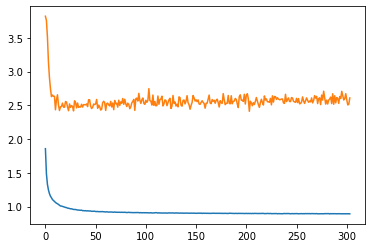

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

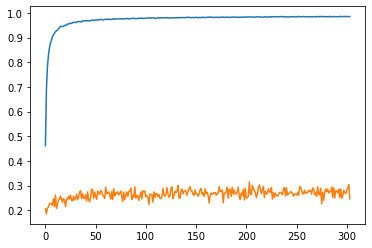

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [25]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [26]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Aug 26 19:11:11 2020 Finding Nearest Neighbors
Wed Aug 26 19:11:11 2020 Building RP forest with 15 trees
Wed Aug 26 19:11:16 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Wed Aug 26 19:11:27 2020 Finished Nearest Neighbor Search
Wed Aug 26 19:11:30 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Aug 26 19:11:57 2020 Finished embedding


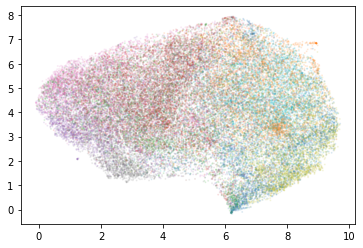

In [27]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Aug 26 19:12:02 2020 Finding Nearest Neighbors
Wed Aug 26 19:12:02 2020 Building RP forest with 10 trees
Wed Aug 26 19:12:02 2020 parallel NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Wed Aug 26 19:12:03 2020 Finished Nearest Neighbor Search
Wed Aug 26 19:12:03 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 26 19:12:22 2020 Finished embedding


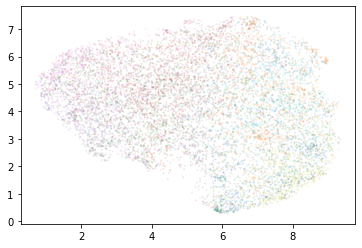

In [28]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

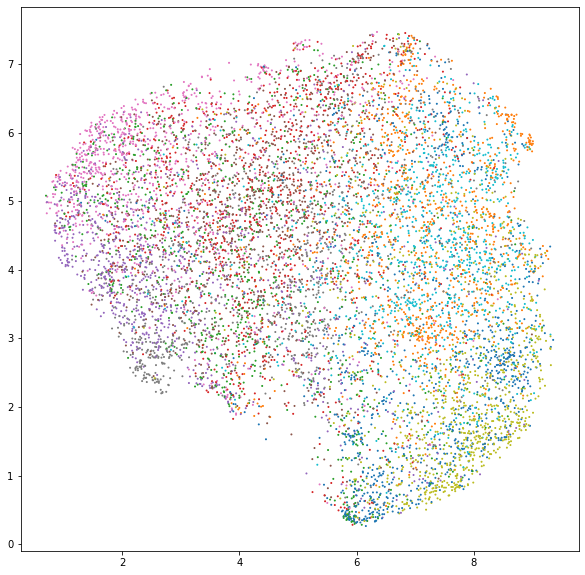

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [30]:
predictions = model.predict(X_valid)

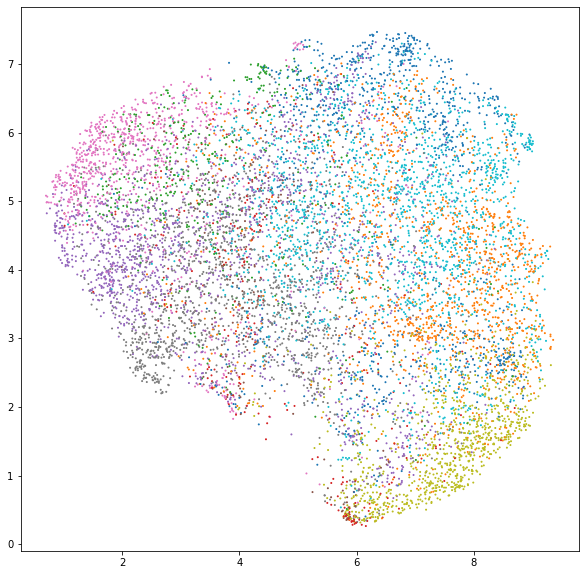

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [32]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 4s 13ms/step - loss: 2.4191 - accuracy: 0.3117


### save results

In [33]:
# save score, valid embedding, weights, results

In [34]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [35]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [36]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [37]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [38]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [39]:
classifier.save_weights((save_folder / "classifier").as_posix())

#### save score

In [40]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 4s 13ms/step - loss: 2.4191 - accuracy: 0.3117


In [41]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [42]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Aug 26 19:12:47 2020 Finding Nearest Neighbors
Wed Aug 26 19:12:47 2020 Building RP forest with 15 trees
Wed Aug 26 19:12:47 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Wed Aug 26 19:12:49 2020 Finished Nearest Neighbor Search
Wed Aug 26 19:12:49 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Aug 26 19:13:16 2020 Finished embedding


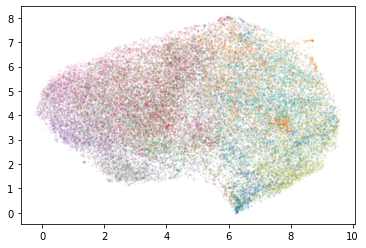

In [43]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [44]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [45]:
import pickle

In [46]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [47]:
print('test')

test
